<a href="https://colab.research.google.com/github/ak-ghoul/Deep-Learning/blob/master/Vectorised_GDAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import seaborn as sb
import imageio
import time
from IPython.display import HTML
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red', 'yellow', 'green', 'blue'])

In [0]:
np.random.seed(0)

In [0]:
data, labels = make_blobs(n_features = 2, n_samples = 1000, centers = 4, random_state = 0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


In [0]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

In [0]:
sb.set()

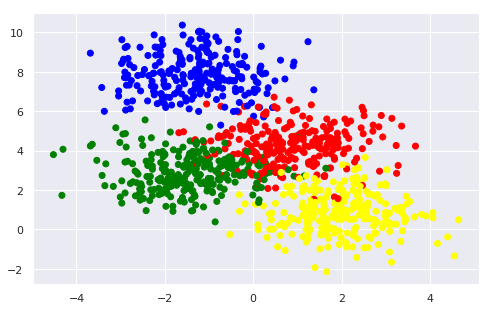

In [0]:
plt.figure(figsize = (8,5))
plt.scatter(data[:,0], data[:,1], c = labels_orig, cmap = my_cmap)
plt.show()

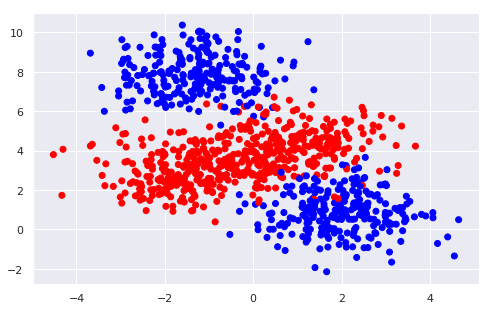

In [0]:
plt.figure(figsize = (8,5))
plt.scatter(data[:,0], data[:,1], c = labels, cmap = my_cmap)
plt.show()

##Multi-Class Classification with different GD Algorithms

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels_orig, stratify = labels_orig, random_state = 0)
print(X_train.shape, Y_test.shape)

(750, 2) (250,)


In [0]:
ohe = OneHotEncoder()
Y_oh_train = ohe.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_oh_test = ohe.fit_transform(np.expand_dims(Y_test, 1)).toarray()
print(Y_oh_train.shape, Y_oh_test.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W2)

[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


In [0]:
class FFNetwork:
  
  def __init__(self, W1, W2):
    
    self.params = {}
    self.params['W1'] = W1.copy()
    self.params['W2'] = W2.copy()
    self.params['B1'] = np.zeros((1,2))
    self.params['B2'] = np.zeros((1,4))
    self.nh = 2  # number of layers. They not hidden layers.Input & output only
    self.gradients = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1,self.nh+1):  # because parameters have been initialized from W1 not W0
      self.update_params['v_w'+str(i)] = 0
      self.update_params['v_b'+str(i)] = 0
      self.update_params['m_w'+str(i)] = 0
      self.update_params['m_b'+str(i)] = 0
      self.prev_update_params['v_w'+str(i)] = 0
      self.prev_update_params['v_b'+str(i)] = 0  
          
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def SoftMax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis = 1).reshape(-1, 1)

  def grad_activation(self, X):
    return X*(1-X)

  def forward_pass(self, X, params = None):
    if params is None:
      params = self.params
    self.A1 = np.matmul(X, params['W1']) + params['B1']
    self.H1 = self.sigmoid(self.A1)
    self.A2 = np.matmul(self.H1, self.params['W2']) + params['B2']
    self.H2 = self.SoftMax(self.A2)   # (N, 4)
    return self.H2
    
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs = 1000, lr = 1, algo = 'GD', display_loss = False, mini_batch_size = 100, eps = 1e-8, beta = 0.9, beta2 = 0.9, beta1 = 0.9, gamma = 0.9):
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), unit = 'epoch', total = epochs):
      m = X.shape[0]

      if algo == 'GD':
        self.grad(X, Y)
        for j in range(1,self.nh+1):
          self.params['W'+str(j)] -= lr * self.gradients['dW'+str(j)]/m
          self.params['B'+str(j)] -= lr * self.gradients['dB'+str(j)]/m
      
      elif algo == 'MiniBatch':
        for j in range(0, m, mini_batch_size):
          self.grad(X[j:j+mini_batch_size], Y[j:j+mini_batch_size])
          for k in range(1,self.nh+1):
            self.params['W'+str(k)] -= lr * self.gradients['dW'+str(k)]/mini_batch_size
            self.params['B'+str(k)] -= lr * self.gradients['dB'+str(k)]/mini_batch_size

      elif algo == 'Momentum':
        self.grad(X, Y)
        for j in range(1,self.nh+1):
          self.update_params['v_w'+str(j)] = self.update_params['v_w'+str(j)] * gamma + lr * self.gradients['dW'+str(j)]/m
          self.update_params['v_b'+str(j)] = self.update_params['v_b'+str(j)] * gamma + lr * self.gradients['dB'+str(j)]/m
          self.params['W'+str(j)] -= self.update_params['v_w'+str(j)]
          self.params['B'+str(j)] -= self.update_params['v_b'+str(j)]
      
      elif algo == 'NAG':
        temp_params = {}
        for j in range(1,self.nh+1):
          self.update_params['v_w'+str(j)] *= gamma
          self.update_params['v_b'+str(j)] *= gamma
          temp_params['W'+str(j)] = self.params['W'+str(j)] - self.update_params['v_w'+str(j)]
          temp_params['B'+str(j)] = self.params['B'+str(j)] - self.update_params['v_b'+str(j)]
        self.grad(X, Y, temp_params)
        for j in range(1,self.nh+1):
          self.update_params['v_w'+str(j)] += lr * self.gradients['dW'+str(j)]/m
          self.update_params['v_b'+str(j)] += lr * self.gradients['dB'+str(j)]/m
          self.params['W'+str(j)] -= lr * self.update_params['v_w'+str(j)]
          self.params['B'+str(j)] -= lr * self.update_params['v_b'+str(j)]
      
      elif algo == 'Adagrad':
        self.grad(X, Y)
        for j in range(1,self.nh+1):
          self.update_params['v_w'+str(j)] += (self.gradients['dW'+str(j)]/m) ** 2
          self.update_params['v_b'+str(j)] += (self.gradients['dB'+str(j)]/m) ** 2
          self.params['W'+str(j)] -= (lr/(np.sqrt(self.update_params['v_w'+str(j)])+ eps)) * self.gradients['dW'+str(j)]/m
          self.params['B'+str(j)] -= (lr/(np.sqrt(self.update_params['v_b'+str(j)])+ eps)) * self.gradients['dB'+str(j)]/m
      elif algo == 'RMSProp':
        self.grad(X, Y)
        for j in range(1,self.nh+1):
          self.update_params['v_w'+str(j)] = beta * self.update_params['v_w'+str(j)] + (1-beta) * (self.gradients['dW'+str(j)]/m)**2
          self.update_params["v_b"+str(j)] = beta*self.update_params["v_b"+str(j)] +(1-beta)*((self.gradients["dB"+str(j)]/m)**2)
          self.params["W"+str(j)] -= (lr/(np.sqrt(self.update_params["v_w"+str(j)]+eps)))*(self.gradients["dW"+str(j)]/m)
          self.params["B"+str(j)] -= (lr/(np.sqrt(self.update_params["v_b"+str(j)]+eps)))*(self.gradients["dB"+str(j)]/m)
      
      elif algo == 'Adam':
        self.grad(X, Y)
        num_updates = 0
        for j in range(1,self.nh+1):
          num_updates += 1
          self.update_params['v_w'+str(j)] = beta2 * self.update_params['v_w'+str(j)] + (1 - beta2) * (self.gradients['dW'+str(j)]/m)**2
          self.update_params['v_b'+str(j)] = beta2 * self.update_params['v_b'+str(j)] + (1 - beta2) * (self.gradients['dB'+str(j)]/m)**2
          self.update_params['m_w'+str(j)] = beta1 * self.update_params['v_w'+str(j)] + (1 - beta1) * (self.gradients['dW'+str(j)]/m)
          self.update_params['m_b'+str(j)] = beta1 * self.update_params['v_b'+str(j)] + (1 - beta1) * (self.gradients['dB'+str(j)]/m)
          m_w_c = self.update_params['m_w'+str(j)]/(1 - np.power(beta1, num_updates))
          m_b_c = self.update_params['m_b'+str(j)]/(1 - np.power(beta1, num_updates))
          v_w_c = self.update_params['v_w'+str(j)]/(1 - np.power(beta2, num_updates))
          v_b_c = self.update_params['v_b'+str(j)]/(1 - np.power(beta2, num_updates))
          self.params['W'+str(j)] -= (lr/(np.sqrt(v_w_c) + eps)) * m_w_c
          self.params['B'+str(j)] -= (lr/(np.sqrt(v_b_c) + eps)) * m_b_c 
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)
    if display_loss:
      plt.plot(loss.values(), '-o', markersize = 5)
      plt.xlabel('Epochs')
      plt.ylabel('Log_loss')
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()


In [0]:
def accuracy():
  Y_pred_train = ffn.predict(X_train)
  Y_train_acc = np.argmax(Y_pred_train, axis = 1)
  Y_pred_test = ffn.predict(X_test)
  Y_test_acc = np.argmax(Y_pred_test, axis = 1)
  print("Training Accuracy :",accuracy_score(Y_train_acc, Y_train))
  print("Testing Accuracy :",accuracy_score(Y_test_acc, Y_test))

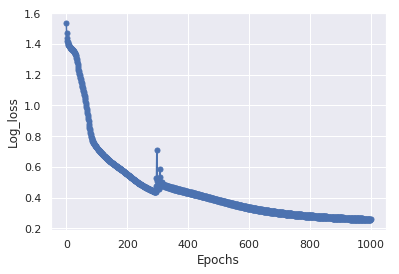

Training Accuracy : 0.8986666666666666
Testing Accuracy : 0.912
CPU times: user 1.87 s, sys: 152 ms, total: 2.02 s
Wall time: 1.89 s


In [0]:
%%time
ffn = FFNetwork(W1,W2)
ffn.fit(X_train, Y_oh_train, epochs=1000, lr=1, algo="GD", display_loss=True)  #see the difference in no of epochs in different algorithms for good accuracy
accuracy()

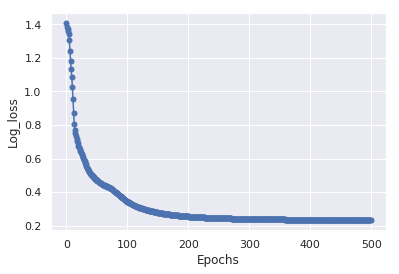

Training Accuracy : 0.9253333333333333
Testing Accuracy : 0.912
CPU times: user 1.29 s, sys: 149 ms, total: 1.44 s
Wall time: 1.31 s


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 500, lr = 1, mini_batch_size = 128, algo = 'MiniBatch', display_loss = True)
accuracy()

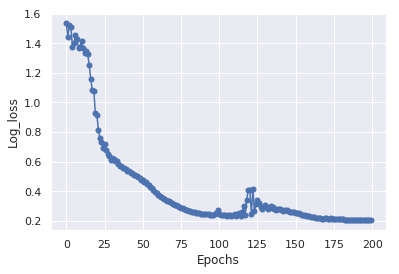

Training Accuracy : 0.916
Testing Accuracy : 0.94
CPU times: user 550 ms, sys: 119 ms, total: 670 ms
Wall time: 540 ms


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 200, lr = 1, gamma = 0.9, algo = 'Momentum', display_loss = True)
accuracy()

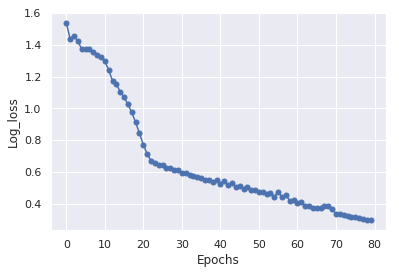

Training Accuracy : 0.8906666666666667
Testing Accuracy : 0.896
CPU times: user 357 ms, sys: 125 ms, total: 482 ms
Wall time: 355 ms


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 80, lr = 1, gamma = 0.9, algo = 'NAG', display_loss = True)
accuracy()

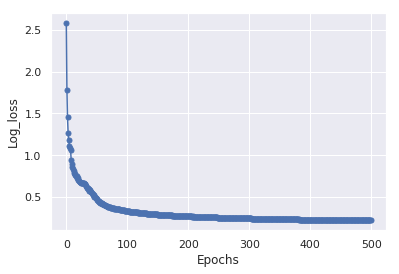

Training Accuracy : 0.912
Testing Accuracy : 0.936
CPU times: user 1.03 s, sys: 118 ms, total: 1.14 s
Wall time: 1.03 s


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 500, lr = 1, algo = 'Adagrad', display_loss = True)
accuracy()

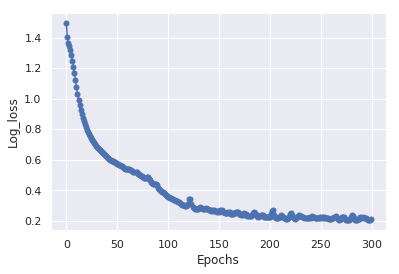

Training Accuracy : 0.9173333333333333
Testing Accuracy : 0.932
CPU times: user 896 ms, sys: 136 ms, total: 1.03 s
Wall time: 883 ms


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 300, lr = 0.1, algo = 'RMSProp', display_loss = True)  #lower lr is producing more effectively for RMSProp
accuracy()

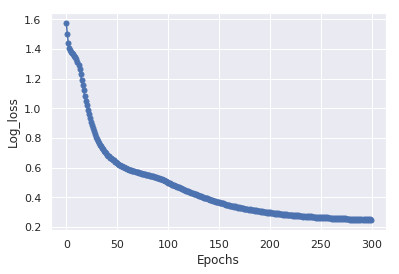

Training Accuracy : 0.908
Testing Accuracy : 0.924
CPU times: user 713 ms, sys: 112 ms, total: 825 ms
Wall time: 718 ms


In [0]:
%%time
ffn = FFNetwork(W1, W2)
ffn.fit(X_train, Y_oh_train, epochs = 300, lr = .1,beta1 = 0.19, beta2 = 0.19, algo = 'Adam', display_loss = True)
accuracy()

In [0]:
l1 = (1,2,3,4)          # a random code snippet to show the memory saving property of python tuples.
l2 = l1
print(id(l2))      # here the id is same as l1
l2 = l2 + (5,)
print(l2)
print(id(l1), id(l2))  # after an operation is performed, id changes

139853663525128
(1, 2, 3, 4, 5)
139853663525128 139853651530592


In [0]:
l1 = [1,2,3,4]
l2 = l1.copy()
l2.append(5)
print(l1)

[1, 2, 3, 4]
